# Over representation  analysis and gene set enrichment analysis 

We first run the same steps as in the previous notebook on multiple testing.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import sys
sys.path.append("..") # Read loacal modules for tcga access and qvalue calculations
import tcga_read as tcga
import qvalue

brca = tcga.get_expression_data("../../data/brca.tsv.gz", 'http://download.cbioportal.org/brca_tcga_pub2015.tar.gz',"data_RNA_Seq_v2_expression_median.txt")
brca_clin = tcga.get_clinical_data("../../data/brca_clin.tsv.gz", 'http://download.cbioportal.org/brca_tcga_pub2015.tar.gz',"data_clinical_sample.txt")
brca.dropna(axis=0, how='any', inplace=True)
brca = brca.loc[~(brca<=0.0).any(axis=1)]
brca = pd.DataFrame(data=np.log2(brca),index=brca.index,columns=brca.columns)
brca_clin.loc["3N"]= (brca_clin.loc["PR status by ihc"]=="Negative") & (brca_clin.loc["ER Status By IHC"]=="Negative") & (brca_clin.loc["IHC-HER2"]=="Negative")
tripple_negative_bool = (brca_clin.loc["3N"] == True)

def get_significance_two_groups(row):
    log_fold_change = row[tripple_negative_bool].mean() - row[~tripple_negative_bool].mean()
    p = ttest_ind(row[tripple_negative_bool],row[~tripple_negative_bool],equal_var=False)[1]
    return [p,-np.log10(p),log_fold_change]

pvalues = brca.apply(get_significance_two_groups,axis=1,result_type="expand")
pvalues.rename(columns = {list(pvalues)[0]: 'p', list(pvalues)[1]: '-log_p', list(pvalues)[2]: 'log_FC'}, inplace = True)
qvalues = qvalue.qvalues(pvalues)

If we investigate a Volcano plot of the tripple negative cancers vs. the other cancers, we see an large number of both up and down regulated genes. We will in this note book ecamine if there are common patterns in the up and down regulation. 

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.relplot(data=qvalues,x="log_FC",y="-log_p")
plt.xlabel("$log_2(FC)$")
plt.ylabel("$-log_{10}(p)$")
plt.show()

<Figure size 500x500 with 1 Axes>

### Over-representation analysis

We use the [gseapy](https://gseapy.readthedocs.io/) module to run an overrepresentation analysis as implemented by the [Enrichr](http://amp.pharm.mssm.edu/Enrichr/). In the analysis we use the [KEGG](https://www.genome.jp/kegg/) database's definition of metabolomic pathways. This choice can easily be changed to other databases such as GO.

Here we select to use the $q$ values below $10^{-15}$ as an input. 

In [3]:
import gseapy as gp

pathway_db=['KEGG_2019_Human']
background=set(qvalues.index)
gene_list = list(qvalues.loc[qvalues["q"]<1e-15,"q"].index)

output_enrichr=pd.DataFrame()
enr=gp.enrichr(
                gene_list=gene_list,
                gene_sets=pathway_db,
                background=background,
                outdir = None
            )


We clean up the results a bit by only keeping some of the resulting metics. We also multiple hypothesis correct our results, and list the terms with a FDR less than 5%.

In [4]:
kegg_enr = enr.results[["P-value","Overlap","Term"]].rename(columns={"P-value": "p"})
kegg_enr = qvalue.qvalues(kegg_enr)
kegg_enr.loc[kegg_enr["q"]<0.05]

,p,Overlap,Term,q
0,6.142575e-11,24/124,Cell cycle,1.558670e-08
1,1.631457e-04,17/160,Cellular senescence,2.069899e-02
2,3.322946e-04,7/35,"Alanine, aspartate and glutamate metabolism",2.810643e-02


### Debugging the Enrichr score

A note, not nececairy a part of the course, but to anyone interested. The Enrichr method claims that they calculate their 
pvalues using a hypergeometric distribution. When trying to recreate the $p$ values of the first term "Cell cycle" where our differential expression list covers 
24 of the pathway's 124 genes we find a differnt probability than anticipated. I can not see the reson for this discrepancey. If you have an explanation, please let me know.

In [5]:
import scipy.stats as stats
pvalue = stats.hypergeom.sf(24,  len(background), 124, len(gene_list))
pvalue

6.797034073626332e-08

## Geneset Enrichment analysis

Subsequently we us pygsea to perform a geneset enricment analysis (GSEA).


In [6]:
classes = ["TrippleNeg" if tripple_negative_bool[sample_name] else "Respond" for sample_name in brca.columns]
gs_res = gp.gsea(data=brca, 
                 gene_sets='KEGG_2016', 
                 cls=classes, # cls=class_vector
                 # set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype',
                 permutation_num=100, # reduce number to speed up test
                 outdir=None,  # do not write output to disk
                 no_plot=True, # Skip plotting
                 method='signal_to_noise',
                 processes=4,
                 format='png')

We list the 5 topscoring pathways.

In [7]:
gs_res.res2d.head()

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Cell cycle_Homo sapiens_hsa04110,-0.505215,-3.577423,0.056911,0.574759,124,119,SKP1;TGFB3;CCNH;CCND1;RB1;CDK7;MDM2;ANAPC2;RBL...,CDK2;CCNE2;YWHAZ;PRKDC;RBX1;ORC3;E2F5;CDC6;CDC...
DNA replication_Homo sapiens_hsa03030,-0.625794,-3.365403,0.094017,0.608568,36,35,POLD4;RPA3;RFC1;RNASEH2C;PRIM1;LIG1;POLA1;POLE...,POLE4;RFC5;POLE;RNASEH2B;POLD2;POLD3;POLE2;RPA...
RNA transport_Homo sapiens_hsa03013,-0.461452,-3.275419,0.055118,0.680695,172,149,EEF1A2;PHAX;EIF4B;EIF4G3;GEMIN8;EIF4EBP3;CASC3...,GEMIN6;NCBP2;NUP155;EIF4A3;NUP37;PNN;GEMIN2;NU...
Epstein-Barr virus infection_Homo sapiens_hsa05169,-0.372759,-3.213429,0.040000,0.683700,202,185,BCL2;IKBKB;MAPK9;HSPA1L;RB1;MDM2;TRAF5;NEDD4;H...,POLR2K;HLA-DRB5;RELA;RBPJ;CD44;HLA-DRB1;HLA-C;...
Spliceosome_Homo sapiens_hsa03040,-0.470595,-3.109381,0.077519,0.717885,134,129,CRNKL1;SLU7;HSPA1L;RBM22;ZMAT2;SRSF6;HSPA2;SRS...,LSM8;SNRPB2;THOC3;SNRPD2;RBMX;HNRNPM;PRPF38B;S...


We display some detailed plots of the best scoring pathway using gseapy's plotting routines.

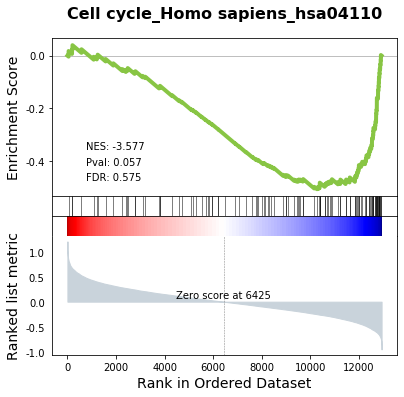

In [8]:
from gseapy.plot import gseaplot, heatmap
terms = gs_res.res2d.index
# Make sure that ``ofname`` is not None, if you want to save your figure to disk
gseaplot(gs_res.ranking, term=terms[0], **gs_res.results[terms[0]])
